In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import datetime
from functions import *
from helpers import *
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
# Github does not accept files above 100mb and test.csv is 104mb
# thus we upload zip whith test.csv which needs to be extracted
with zipfile.ZipFile("../data/test.csv.zip","r") as zip_ref:
    zip_ref.extractall("../data/")

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, x, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
#Lets verify loaded data
print(y.shape)
print(x.shape)
print(ids.shape)

y = np.reshape(y, (len(y), 1))
#y_vec = np.zeros((y.shape[0], 1))
#y_vec[:,0] = y

print(y[2])

In [ ]:
x_s = standardize(x)
eigenvectors, eigenvalues, V = np.linalg.svd(x.T, full_matrices=False)
x_proj = np.dot(x, eigenvectors[:, 0:12])
print(eigenvectors.shape)
print(eigenvalues.shape)
print(V.shape)
print(x_proj.shape)
sigma = x_proj.std(axis=0).mean()
print(sigma)

# Do your thing crazy machine learning thing here :) ...

In [ ]:
max_iter = 100
threshold = 1e-8
alpha = 0.001
ratio = 0.1
lambd = 0.01
losses = []

y = np.reshape(y, (len(y), 1))


x_train, x_test, y_train, y_test = split_data(x, y_vec, ratio)
tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
w = np.zeros((tx_train.shape[1], 1))

In [ ]:
print(x_train.shape)
print(x_test.shape[0]+x_train.shape[0])
print(x.shape[0])

In [ ]:
loss, w = learning_by_newton_method(y_train, tx_train, w, alpha)
losses.append(loss)
print(loss)

In [38]:
max_iter = 5
threshold = 1e-8
alpha = 0.001
#lambd = 0.001
ratio = 0.1
losses = []

lambds = np.logspace(-9, -1, 10)
y = np.reshape(y, (len(y), 1))
x_train, x_test, y_train, y_test = split_data(x, y, ratio)

#tx_train, x_tr_mean, x_tr_std = standardize(x_train)
#tx_test, x_te_mean, x_te_std = standardize(x_test)

tx_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]
for lamb in lambds:
    loss, w = reg_logistic_regression(y_train, tx_train, lamb, alpha, max_iter)
    lossREG = compute_loss(y_test, tx_test, w)
    rmse = np.sqrt(2*lossREG)
    losses.append(rmse)

/home/laz/Documents/PCML/MachineLearning/Projects/project1/scripts/functions.py:222: RuntimeWarning: invalid value encountered in true_divide
  gradient_penalty = lambd * 2 * w / np.linalg.norm(w)


ValueError: Data has no positive values, and therefore can not be log-scaled.

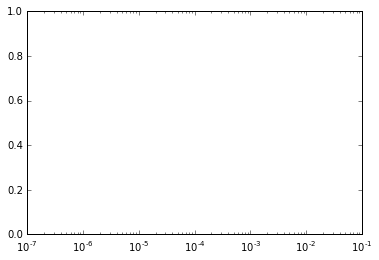

In [40]:
plt.semilogx(lambds, losses, marker=".", color='b')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.grid(True)

In [ ]:
#Lets test some basics: Least Squares Gradient Descent
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
#max_iters = 1
#gamma = 0.4
#batch_size = 300
max_iter = 1000
threshold = 1e-8
alpha = 0.002
lambd = 0.001
ratio = 0.1
losses = []

# Initialization
#w_initial = weights

y = np.reshape(y, (len(y), 1))

x_train, x_test, y_train, y_test = split_data(x, y, ratio)

#tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
#tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]

tx_train, x_tr_mean, x_tr_std = standardize(x_train)
tx_test, x_te_mean, x_te_std = standardize(x_test)
w = np.zeros((tx_train.shape[1], 1))

start_time = datetime.datetime.now()
# start the logistic regression
for iter in range(max_iter):
    # get loss and update w.
    loss, w = learning_by_gradient_descent(y_train, tx_train, w, alpha)
    if iter % 20 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    losses.append(loss)
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        break
# visualization
#visualization(y_train, x_train, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
print("The loss={l}".format(l=compute_loss(y_test, tx_test, w)))
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
best_weights = w

In [ ]:
best_weights_std = w

In [ ]:
try1, x_mean, std_x = standardize(x)
#try1 = np.reshape(try1, (x.shape[0], x.shape[1]))
print(try1.shape)

In [ ]:
weights = w
print("RMSE: {l}".format(l=compute_RMSE(y_test, tx_test, w)))
k_fold = 10
seed = 1
lambd = 0.01
w_cv, lossTR_cv, lossTE_cv = cross_validation(y_vec, x, k_fold, seed, lambd)

In [ ]:
# Define the parameters of the algorithm.
#max_iters = 1
#gamma = 0.4
#batch_size = 300
max_iter = 100
threshold = 1e-8
alpha = 0.002
lambd = 0.001
ratio = 0.1
losses = []

# Initialization
#w_initial = weights

y_vec = np.zeros((y.shape[0], 1))
y_vec[:,0] = y

x_train, x_test, y_train, y_test = split_data(x, y_vec, ratio)
tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.zeros((tx_train.shape[1], 1))

start_time = datetime.datetime.now()
# start the logistic regression
for iter in range(max_iter):
    # get loss and update w.
    loss, w = learning_by_newton_method(y_train, tx_train, w, alpha)
    if iter % 20 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    losses.append(loss)
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        break
# visualization
#visualization(y_train, x_train, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
print("The loss={l}".format(l=compute_RMSE(y_test, tx_test, w)))
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

# PCA

In [ ]:
#max_iters = 1
#gamma = 0.4
#batch_size = 300
max_iter = 10
threshold = 1e-8
alpha = 0.001
lambd = 0.001
ratio = 0.1
losses = []

eigenvectors, eigenvalues, V = np.linalg.svd(x.T, full_matrices=False)
x_proj = np.dot(x, eigenvectors[:, 0:10])
y = np.reshape(y, (len(y), 1))

x_train, x_test, y_train, y_test = split_data(x_proj, y, ratio)
tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.zeros((tx_train.shape[1], 1))

start_time = datetime.datetime.now()
# start the logistic regression
for iter in range(max_iter):
    # get loss and update w.
    loss, w = learning_by_newton_method(y_train, tx_train, w, alpha)
    if iter % 10 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    losses.append(loss)
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
        break
# visualization
#visualization(y_train, x_train, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")

mse = compute_loss(y_test, tx_test, w)
rmse = np.sqrt(2*mse)
print("The loss={l}".format(l=rmse))
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Newton: execution time={t:.3f} seconds".format(t=exection_time))



# ERROR

In [ ]:
mse = compute_loss(y_test, tx_test, w)
rmse = np.sqrt(2*mse)
print(rmse)

# K-fold

In [ ]:
max_iter = 40
threshold = 1e-8
alpha = 0.001
lambd = 0.001
ratio = 0.1
losses = []
k_fold = 20
seed = 1

#x_train, x_test, y_train, y_test = split_data(x, y, ratio)
#tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
#tx_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
w = np.zeros((tx_train.shape[1], 1))
y = np.reshape(y, (len(y), 1))

w_LS, tr_rmse, te_rmse = cross_validation(y, x, k_fold, seed, lambd, max_iter)
print(w_LS.std(axis=0).mean())
print(tr_rmse)
print(te_rmse)

In [ ]:
weights_NM_20folds = w_LS
train_rmse_NM_20folds = tr_rmse
test_rmse_NM_20folds = te_rmse

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)

tX_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]


In [ ]:
weights = best_weights_std

In [ ]:
OUTPUT_PATH = '../data/submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
# Delete train.csv such that github accepts push
os.remove('../data/test.csv')